In [1]:
using Plots
using ColorSchemes
using LaTeXStrings
using LinearAlgebra
using ControlSystemsBase
using BehavioralSystems

  ** incremental compilation may be fatally broken for this module **



In [2]:
n = 3
m = 2
p = 1
q = m+p
sys = drss(n,m,p)

StateSpace{Discrete{Float64}, Float64}
A = 
 -0.9394297437038556  -1.2471629461314506    -0.3780098849564888
  0.5662026278471379  -0.001726914346506514  -0.13679387996441833
  1.035203138988655    1.6765416963192936     0.5628185544398272
B = 
 -0.062341859912040665   1.1066633362531684
  1.4471625731431188    -0.5959511825921002
 -0.49858972890871806    0.09417584730583647
C = 
 0.7865024431060044  -0.0  0.40597262300939135
D = 
 -1.0778538726422282  0.0

Sample Time: 1.0 (seconds)
Discrete-time state-space model

In [3]:
T = 10
Π = canonical_permutation(m,p,T)

ℬ_mb = ss2BT_modelbased(sys, nothing, T)
ℬ_1 = ℬ_mb[Π,:]
ℬ_2 = ss2BT_datadriven(sys, T)
ℬ_3 = ss2BT_hankel(sys, T)

30×23 Matrix{Float64}:
 -0.20653   -0.165117    0.118081    …  -0.0639196   0.606387     0.273348
 -0.195222   0.15974    -0.0562839      -0.135103   -0.0646629    0.04991
  0.146428   0.393745   -0.143767        0.224902    0.182095     0.0337334
 -0.20123   -0.154471   -0.0109562       0.39385    -0.123004     0.138382
 -0.196152   0.174145    0.220902       -0.182408   -0.190669    -0.318681
  0.138473   0.327834   -0.181236    …  -0.103828    0.212372     0.0267769
 -0.206782  -0.112727   -0.0324866       0.0394833   0.214888    -0.210428
 -0.183976   0.0132096   0.364976        0.23688    -0.0475261    0.120292
  0.143335   0.275875    0.277939       -0.0114244   0.0818767    0.252231
 -0.212485  -0.0641574  -0.0587629      -0.27896    -0.165457     0.144792
  ⋮                                  ⋱   ⋮                       
 -0.20365    0.145388   -0.135098       -0.0766601  -0.288306     0.166821
 -0.181464  -0.110079    0.00902912      0.180402    0.0294157   -0.352762
  0.151434

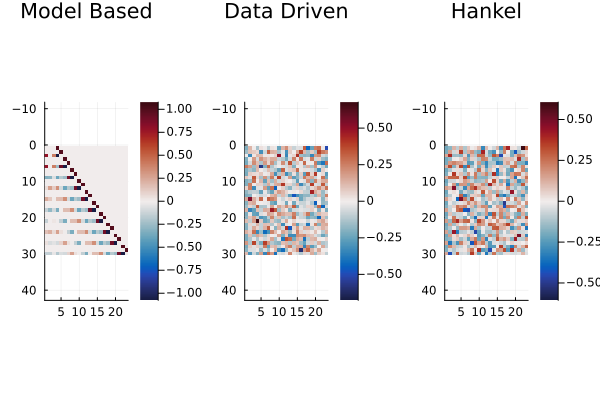

In [40]:
v1 = maximum(abs.(ℬ_1))
v2 = maximum(abs.(ℬ_2))
v3 = maximum(abs.(ℬ_3))
cmap = :balance
p1 = heatmap(ℬ_1, yflip=true, title="Model Based", 
color = cmap, clims=(-v1,v1), aspect_ratio=:equal)
p2 = heatmap(ℬ_2, yflip=true, title="Data Driven", 
color = cmap, clims=(-v2,v2), aspect_ratio=:equal)
p3 = heatmap(ℬ_3, yflip=true, title="Hankel", 
color = cmap, clims=(-v3,v3), aspect_ratio=:equal)
p_ = plot(p1, p2, p3, layout=(1,3))
savefig(p_, "ss2BT.pdf")
p_

In [5]:
rank(ℬ_1), rank(ℬ_2), rank(ℬ_3), T*m + n

(23, 23, 23, 23)

In [6]:
rank([ℬ_1 ℬ_3]), rank([ℬ_1 ℬ_2]), rank([ℬ_2 ℬ_3])

(24, 24, 23)

In [23]:
d = zeros(T)
d_2 = zeros(T)
#d_3 = zeros(T)
w = random_trajectory(sys,5*T)
for t in 1:T
    d[t] = rank(ss2BT_modelbased(sys, nothing, t))
    d_2[t] = rank(ss2BT_hankel(w, t))
    #d_3[t] = rank(obsv(sys,t))
end

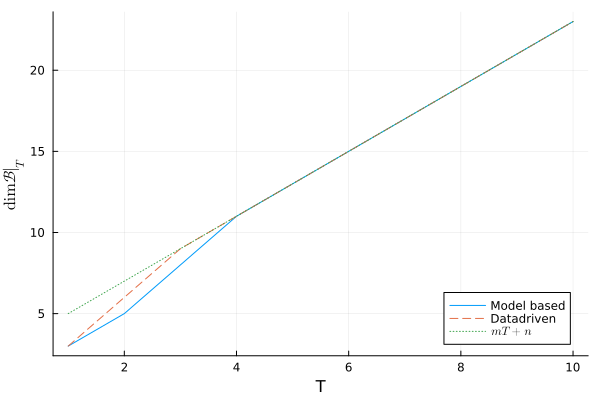

In [24]:
plot(d, 
label="Model based",
xlabel="T",
ylabel=L"\dim \mathcal{B}|_T",
)
#plot!(d_3, label="Observability Matrix")
plot!(d_2, label="Datadriven", linestyle=:dash)
plot!(1:10, n.+m.*(1:10), label=L"mT+n", linestyle=:dot)

In [25]:
lag_modelbased(sys), lag_datadriven(sys)

(3, 3)

In [36]:
w = random_trajectory(sys, 20)
ℓ = lag_datadriven(w)

3

In [34]:
R_mb = ss2r_modelbased(sys)
Π = canonical_permutation(m,p,ℓ+1)
R_1 = R_mb[:,Π]
R_2 = ss2r_datadriven(sys)

1×12 adjoint(::Matrix{Float64}) with eltype Float64:
 0.000304727  -0.224498  -5.1131e-16  …  0.428236  6.40709e-16  0.397304

In [37]:
w_ = random_trajectory(sys, ℓ+1)
R_1 * vec(w_), R_2 * vec(w_)

([-0.07633537585480321], [-3.0531133177191805e-16])

In [27]:
complexity_datadriven(w)

(2, 3, 3)

In [28]:
complexity_mpum(w)

(2, 3, 2)

In [38]:
most_powerful_unfalsified_model(w)

0×9 adjoint(::Matrix{Float64}) with eltype Float64

In [54]:
T_ = 20
T_d = (m+1)*T_ + n
w_d = random_trajectory(sys, T_d)
w = random_trajectory(sys, T_)
w_h = data_interpolation(w_d, w)
w, w_h

([0.7706081552151589 0.4915431216559999 … 0.39013526178285196 0.7455115037625902; 0.30613384024475565 0.21095786496861169 … 0.5825339544461305 0.9446178441050908; -0.1872477743498988 -0.9484115186648369 … 0.07184400549806502 -0.818939461878813], [0.770647446006993 0.49150544465979373 … 0.390069115405188 0.7454599822799065; 0.30624879026159113 0.21108211404330865 … 0.5826817614306316 0.9446639847359478; -0.18724285423903958 -0.9484900960628825 … 0.07178116903093242 -0.8189994992208038])

In [55]:
norm(w-w_h)

0.0007857367114210705

In [57]:
w_h_2 = data_interpolation(sys, w)
norm(w-w_h_2)

0.0006191864454026712

In [59]:
S = ones(size(w))
S[:,1:5] .= 0.0
w_h_3 = data_interpolation(w_d, w; S=S)
norm(w-w_h_3)


1.1910918899668907

In [56]:
w_2 = w .+ 0.01*randn(size(w))
w_2h = data_interpolation(w_d, w_2)
norm(w-w_2), norm(w-w_2h)

(0.06018198335669129, 0.056623105733946535)